# Read Irish CER smart meter data & initial data cleaning

In [21]:
# import  module containing all functions written for MSc project
import mscprojectcoding.FM_MScProject_LoadForecasting_Module as FMmodule


In [22]:
# force reimport of module after edits/updates to functions in PyCharm 
import importlib
importlib.reload(FMmodule)

<module 'mscprojectcoding.FM_MScProject_LoadForecasting_Module' from 'c:\\users\\fmurphy\\onedrive - loughborough university\\fm-project\\mscprojectcoding\\src\\mscprojectcoding\\FM_MScProject_LoadForecasting_Module.py'>

In [ ]:
#import functions 
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  get_limits                 # get x,y limits for plot axis
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  get_uniques                # get unique values from dataframe columns or pd.series?
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  show_mem_usage             # shows total memory usage
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  get_data_range
from mscprojectcoding.FM_MScProject_LoadForecasting_Module import  get_NaN_stats              # get stats for NaNs in each column


In [2]:
import pandas as pd
import numpy as np
import time             
import re
import sys
import pickle
import math
import glob
import datetime
import matplotlib.pyplot as plt  
%matplotlib inline

In [3]:
# Set max lines etc to display, print etc
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100) # sets limit to print o/p; 
#pd.set_option('display.max_rows', None) # sets no limit to print o/p; only use if reading some of rows

In [ ]:
# Pre processing and checking of data 

start_time = time.time()

column_names=['meterID', 'dayTimeCode','kWh30']
subset_column_names=['meterID']

#use category dtype for columns with many redundant entries (all subset_column_names)     # x3 reduction in memory usage
dtypes = {'meterID':'category'}

CHUNKsize = 1000000   
count = 0

# set correct path after unzip files
filelist = glob.glob('.\..\Data\Ireland CER Data\*.txt')
#print(filelist)
#filename = '.\..\Data\Ireland CER Data\File1.txt'

#create empty df for o/p
df_unique_users = pd.DataFrame()        # for list of unique users 
df_selected_data = pd.DataFrame()       # output data

for f in filelist:
    iterator = pd.read_csv(f,header=0,iterator=True,names=column_names,chunksize=CHUNKsize,dtype=dtypes,sep=' ')   
    count = 0

    for df in iterator:                                                     
        count +=1     # increment chunk count
    
        #remove rows where load data NULL - ignore for now 
        #df = df[df['kWh30'] != 'Null']    

        #get list of unique userIDs (meterID) and append to
        uniques = get_uniques(df,subset_column_names)
        df_unique_users = pd.concat([df_unique_users,uniques])
      
        # convert load data (pandas object) to numeric
        #https://stackoverflow.com/questions/40095712/when-to-applypd-to-numeric-and-when-to-astypenp-float64-in-python    
        df['kWh30'] = pd.to_numeric(df['kWh30'],errors='coerce')               
    
        df_selected_data = pd.concat([df_selected_data,df])  
        print("Chunk count is:",count)

#run unique filter again on usereID dataframe - lots of duplicates from meterID overlap across chunk boundaries etc 
df_unique_users = get_uniques(df_unique_users,'meterID')
df_unique_users.to_csv('../MScProjectCoding/project_data//intermediateDataIreland/CERuserID_Summary.csv')


#find rows with null load data (if any)
null_data = df_selected_data[df_selected_data['kWh30'] == 'Null']
null_data.to_csv('../MScProjectCoding/project_data//intermediateDataIreland/null_data.csv')

#check memory use at end 
#show_mem_usage() 

# EXPORT SELECTED DATA TO PICKLE FILE 
df_selected_data.to_pickle('../MScProjectCoding/project_data/intermediateDataIreland/CER_Data_All.pkl')

# calculate execution time and print
print("--- %s seconds ---" % (time.time() - start_time)) 


In [32]:
df_selected_data = pd.read_pickle('../MScProjectCoding/project_data/intermediateDataIreland/CER_Data_All.pkl')  # read pickled file 
df_unique_users = pd.read_csv('../MScProjectCoding/project_data/intermediateDataIreland/CERuserID_Summary.csv')


In [33]:
#check output dataframe

print(df_selected_data.shape)   
print(df_selected_data.info)
print(df_selected_data.dtypes)
print(df_unique_users)

(157992990, 3)
<bound method DataFrame.info of          meterID  dayTimeCode  kWh30
0           1392        19504  0.138
1           1392        19505  0.140
2           1392        19506  0.145
3           1392        19507  0.145
4           1392        19501  0.157
...          ...          ...    ...
35436006    6269        73044  0.425
35436007    6269        73045  0.385
35436008    6269        73046  0.431
35436009    6269        73047  0.459
35436010    6269        73048  0.515

[157992990 rows x 3 columns]>
meterID         object
dayTimeCode      int64
kWh30          float64
dtype: object
      Unnamed: 0  meterID  dayTimeCode  kWh30
0              0     1392        19504  0.138
1            287     1951        19604  0.042
2            575     1491        19640  0.837
3            863     1194        19501  0.399
4           1151     1804        19601  0.102
...          ...      ...          ...    ...
6430    10199269     6114        34943  2.406
6431    16398325     7426  

In [ ]:
# extract day and time codes using math (quicker than using str) - generate a datetime column
start_time = time.time()

def first_three(d):                
    return (d // 10 ** (int(math.log(d, 10)) - 2))
    
df_selected_data['day'] = df_selected_data.dayTimeCode.apply(first_three)
df_selected_data['tIdx'] = (df_selected_data['dayTimeCode'] - 100*df_selected_data['day'])/2
print(df_selected_data)

# calculate execution time and print
print("--- %s seconds ---" % (time.time() - start_time)) 


In [ ]:
# convert day and hour to datetime
refDate = datetime.datetime(2009, 1, 1, 0, 0)
t1=pd.to_timedelta(df_selected_data['day'], unit='days', errors='raise')
t2=pd.to_timedelta(df_selected_data['tIdx'], unit='hours', errors='raise')
df_selected_data['date_time']=refDate+t1+t2
del t1,t2

In [ ]:
df_selected_data.to_pickle('../MScProjectCoding/project_data/intermediateDataIrelandCER_Data_All_step2.pkl')

In [ ]:
df_selected_data = pd.read_pickle('../MScProjectCoding/project_data/intermediateDataIrelandCER_Data_All_step2.pkl')

In [ ]:
print(df_selected_data.dtypes)
df_selected_data

In [ ]:
# get range of date_time for each meterID
df_datetime_bounds=pd.DataFrame()
df_datetime_bounds = get_data_range(df_selected_data,'meterID','date_time')
df_datetime_bounds
df_datetime_bounds.to_csv('.\intermediateData_Ireland\CER_userID_DateTimeRange.csv')


In [ ]:
#define date range to keep in output: most of meterID have data from 17/July09 to 02/Jan/11

# keep just the 2010 data for now

start = '2010-01-01 00:00:00'
end = '2011-01-01 00:00:00'

#only keep data in start:end date range from main df
df_selected_data = df_selected_data[(df_selected_data['date_time'] >= start) & (df_selected_data['date_time'] < end) ] 
df_selected_data

In [ ]:
# find if any NaNs in df  

print("Total Nrows in df_selected_data: ",df_selected_data.shape[0])
print(get_NaN_stats(df_selected_data)) 


In [ ]:
# drop extra columns
df_selected_data=df_selected_data.drop(['dayTimeCode','day','tIdx'],axis=1)
df_selected_data


In [ ]:
# sort (not sure if needed)
# NB if use inplace, don't reassign as pd.sort_values returns NONE.
df_selected_data.sort_values(by=['meterID', 'date_time'],inplace=True)

In [ ]:
df_selected_data.to_pickle('../MScProjectCoding/project_data/intermediateDataIrelandCER_Data_All_step3.pkl')

In [6]:
df_selected_data = pd.read_pickle('../MScProjectCoding/project_data/intermediateDataIrelandCER_Data_All_step3.pkl')

In [7]:
# show gap (all meters have 1.5 hr gap on 29/Mar/2010 01:30)
#df_selected_data.loc[(df_selected_data['meterID']=='1000') & (df_selected_data['date_time'] > '2010-03-28 23:00:00')]

In [8]:
# drop duplicates - take first row where duplicate of date_time and meterID but not load (few duplicates ~ 2/nov?)
#df_selected_data_noDups = df_selected_data.drop_duplicates(subset=['meterID','date_time'])
#print(df_selected_data_noDups.shape)

df_selected_data.drop_duplicates(subset=['meterID','date_time'],inplace=True)
print(df_selected_data.shape)
df_selected_data

(106344469, 3)


,meterID,kWh30,date_time
8129487,1000,0.081,2010-01-01 00:00:00
8129769,1000,0.079,2010-01-01 00:30:00
8129770,1000,0.114,2010-01-01 01:00:00
8129771,1000,0.058,2010-01-01 01:30:00
8129772,1000,0.105,2010-01-01 02:00:00
...,...,...,...
30447782,7444,1.457,2010-10-18 22:00:00
30447783,7444,1.811,2010-10-18 22:30:00
30447784,7444,1.054,2010-10-18 23:00:00
30447785,7444,0.925,2010-10-18 23:30:00


In [9]:
# get nrows per meterID :  
df_row_count = pd.DataFrame(df_selected_data.groupby('meterID')['date_time'].count())
df_row_count.columns = ['value_count']
print("nrows per meterID: ",df_row_count)
df_row_count.to_csv('../MScProjectCoding/project_data/intermediateDataIreland/CER_DataRowsPerUser.csv')
df_row_count.groupby('value_count')['value_count'].count()

nrows per meterID:           value_count
meterID             
1000           17518
1001           17518
1002           17518
1003           17518
1004           17518
...              ...
7440           17470
7441           17518
7442           17518
7443           17518
7444           13967

[6290 rows x 1 columns]


value_count
48          9
98          1
144         1
192         3
193         2
         ... 
17422     214
17423       1
17470     916
17471       2
17518    4643
Name: value_count, Length: 256, dtype: int64

In [10]:
#select meterID with FEW missing times in selected date range   
threshold=17518   # ie. only max 2 or 3 missing hr values
meterID_keep = df_row_count.loc[df_row_count['value_count'] >= threshold]          
meterID_keep.to_csv('../MScProjectCoding/project_data/intermediateDataIreland/CER_meterID_keep.csv')
meterID_keep                                # this is sorted by meterID


,value_count
meterID,
1000,17518
1001,17518
1002,17518
1003,17518
1004,17518
...,...
7437,17518
7438,17518
7441,17518


In [11]:
meterID_keep.index

Index(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1009', '1013',
       '1014',
       ...
       '7432', '7433', '7434', '7435', '7436', '7437', '7438', '7441', '7442',
       '7443'],
      dtype='object', name='meterID', length=4643)

In [12]:
df_selected_data['meterID']

8129487     1000
8129769     1000
8129770     1000
8129771     1000
8129772     1000
            ... 
30447782    7444
30447783    7444
30447784    7444
30447785    7444
30447786    7444
Name: meterID, Length: 106344469, dtype: object

In [13]:
# now subset data to only keep meterID where near complete/complete set of data for 2010 

# x isin(y) where x=pandas.core.series.Series, y=pandas.core.indexes.base.Index, both dtype object

df_selected_data= df_selected_data.loc[df_selected_data['meterID'].isin(meterID_keep.index)]
print(" Subset Data size :  ",df_selected_data.shape)
df_selected_data


 Subset Data size :   (81336074, 3)


,meterID,kWh30,date_time
8129487,1000,0.081,2010-01-01 00:00:00
8129769,1000,0.079,2010-01-01 00:30:00
8129770,1000,0.114,2010-01-01 01:00:00
8129771,1000,0.058,2010-01-01 01:30:00
8129772,1000,0.105,2010-01-01 02:00:00
...,...,...,...
35346101,7443,0.545,2010-12-31 21:30:00
35346102,7443,0.606,2010-12-31 22:00:00
35346103,7443,0.515,2010-12-31 22:30:00
35346104,7443,0.195,2010-12-31 23:00:00


In [14]:
# find if any  gaps in date_time 

df_time_gaps = df_selected_data.loc[(df_selected_data['meterID'] == df_selected_data['meterID'].shift(-1))&(df_selected_data['date_time'].diff() > '00:30:00')]
df_time_gaps.to_csv('../MScProjectCoding/project_data/intermediateDataIreland/CER2010_time_gaps.csv')
print(df_time_gaps)

# where time gap, extract preceeding row (for checking)
df_selected_data_Gaps = df_selected_data[df_selected_data.index.isin((df_time_gaps.index)-1)]
print(df_selected_data_Gaps)

print("Nrows (with time gaps):", df_time_gaps.shape[0])

# count for each meterID, number of rows with gaps 
df_time_gaps.groupby('meterID')['date_time'].count()

# count total number of meterID with gaps 
df_time_gaps_uniqueID = df_time_gaps.drop_duplicates(subset='meterID')
print("total number of meterID with gaps  : ",df_time_gaps_uniqueID.shape[0])     

print("time gaps: :",df_time_gaps)

         meterID  kWh30           date_time
11895274    1000  0.024 2010-03-29 02:00:00
11860382    1001  0.196 2010-03-29 02:00:00
11937316    1002  0.035 2010-03-29 02:00:00
11879544    1003  0.387 2010-03-29 02:00:00
11812334    1004  0.511 2010-03-29 02:00:00
...          ...    ...                 ...
17176258    7437  0.161 2010-03-29 02:00:00
17399052    7438  0.000 2010-03-29 02:00:00
17325264    7441  0.199 2010-03-29 02:00:00
17414210    7442  0.245 2010-03-29 02:00:00
17343854    7443  0.125 2010-03-29 02:00:00

[4643 rows x 3 columns]
         meterID  kWh30           date_time
11895119    1000  0.316 2010-03-25 19:30:00
11895137    1000  0.108 2010-03-26 04:30:00
11895267    1000  0.029 2010-03-28 21:30:00
11895273    1000  0.024 2010-03-29 00:30:00
17077015    1000  0.214 2010-07-18 12:00:00
...          ...    ...                 ...
12011283    7441  0.508 2010-01-06 13:00:00
12011383    7441  0.673 2010-01-08 15:00:00
17325263    7441  0.418 2010-03-29 00:30:00
1741420

In [15]:
# test interpolation of missing rows/time values
#df_selected_data_TEST=df_selected_data
df_selected_data=df_selected_data.set_index('date_time')
df_selected_data

,meterID,kWh30
date_time,,
2010-01-01 00:00:00,1000,0.081
2010-01-01 00:30:00,1000,0.079
2010-01-01 01:00:00,1000,0.114
2010-01-01 01:30:00,1000,0.058
2010-01-01 02:00:00,1000,0.105
...,...,...
2010-12-31 21:30:00,7443,0.545
2010-12-31 22:00:00,7443,0.606
2010-12-31 22:30:00,7443,0.515


In [16]:
# add missing rows (just 2 ) - fill load values with NaN 
df_selected_data_resmpl=df_selected_data.groupby('meterID').resample('30T').mean()
df_selected_data_resmpl

kWh30
meterID date_time                 
1000    2010-01-01 00:00:00  0.081
        2010-01-01 00:30:00  0.079
        2010-01-01 01:00:00  0.114
        2010-01-01 01:30:00  0.058
        2010-01-01 02:00:00  0.105
...                            ...
7443    2010-12-31 21:30:00  0.545
        2010-12-31 22:00:00  0.606
        2010-12-31 22:30:00  0.515
        2010-12-31 23:00:00  0.195
        2010-12-31 23:30:00  0.174

[81345360 rows x 1 columns]

In [17]:
# reset to single index df
df_selected_data_resmpl=df_selected_data_resmpl.reset_index(level=['meterID'])
df_selected_data_resmpl

,meterID,kWh30
date_time,,
2010-01-01 00:00:00,1000,0.081
2010-01-01 00:30:00,1000,0.079
2010-01-01 01:00:00,1000,0.114
2010-01-01 01:30:00,1000,0.058
2010-01-01 02:00:00,1000,0.105
...,...,...
2010-12-31 21:30:00,7443,0.545
2010-12-31 22:00:00,7443,0.606
2010-12-31 22:30:00,7443,0.515


In [18]:
# if wish to linearly interpolate NaNs
df_selected_data_resmpl['kWh30'] = df_selected_data_resmpl['kWh30'].interpolate()
df_selected_data_resmpl['kWh30'] 

date_time
2010-01-01 00:00:00    0.081
2010-01-01 00:30:00    0.079
2010-01-01 01:00:00    0.114
2010-01-01 01:30:00    0.058
2010-01-01 02:00:00    0.105
                       ...  
2010-12-31 21:30:00    0.545
2010-12-31 22:00:00    0.606
2010-12-31 22:30:00    0.515
2010-12-31 23:00:00    0.195
2010-12-31 23:30:00    0.174
Name: kWh30, Length: 81345360, dtype: float64

In [19]:
# verify complete dataset 17520 nrows per meterID 
df_row_count = pd.DataFrame(df_selected_data_resmpl.groupby('meterID')['meterID'].count())
df_row_count.columns = ['value_count']
print("nrows per meterID: ",df_row_count)


nrows per meterID:           value_count
meterID             
1000           17520
1001           17520
1002           17520
1003           17520
1004           17520
...              ...
7437           17520
7438           17520
7441           17520
7442           17520
7443           17520

[4643 rows x 1 columns]


In [21]:
df_selected_data_resmpl

,meterID,kWh30
date_time,,
2010-01-01 00:00:00,1000,0.081
2010-01-01 00:30:00,1000,0.079
2010-01-01 01:00:00,1000,0.114
2010-01-01 01:30:00,1000,0.058
2010-01-01 02:00:00,1000,0.105
...,...,...
2010-12-31 21:30:00,7443,0.545
2010-12-31 22:00:00,7443,0.606
2010-12-31 22:30:00,7443,0.515


In [23]:
# check gap filled with NaN or interpolated
df_selected_data_resmpl.loc[(df_selected_data_resmpl['meterID']=='1000') & (df_selected_data_resmpl.index > '2010-03-29 00:00:00')]


,meterID,kWh30
date_time,,
2010-03-29 00:30:00,1000,0.024
2010-03-29 01:00:00,1000,0.024
2010-03-29 01:30:00,1000,0.024
2010-03-29 02:00:00,1000,0.024
2010-03-29 02:30:00,1000,0.024
...,...,...
2010-12-31 21:30:00,1000,0.489
2010-12-31 22:00:00,1000,0.541
2010-12-31 22:30:00,1000,0.518


In [24]:
#temporary
#df_selected_data_resmpl=df_selected_data_TEST2
df_selected_data_resmpl['date_time']=df_selected_data_resmpl.index


In [25]:
df_selected_data_resmpl

,meterID,kWh30,date_time
date_time,,,
2010-01-01 00:00:00,1000,0.081,2010-01-01 00:00:00
2010-01-01 00:30:00,1000,0.079,2010-01-01 00:30:00
2010-01-01 01:00:00,1000,0.114,2010-01-01 01:00:00
2010-01-01 01:30:00,1000,0.058,2010-01-01 01:30:00
2010-01-01 02:00:00,1000,0.105,2010-01-01 02:00:00
...,...,...,...
2010-12-31 21:30:00,7443,0.545,2010-12-31 21:30:00
2010-12-31 22:00:00,7443,0.606,2010-12-31 22:00:00
2010-12-31 22:30:00,7443,0.515,2010-12-31 22:30:00


In [26]:
# no reorganize dataframe - unstack/rearrange data
df_selected_data_rearranged = df_selected_data_resmpl.pivot(index='meterID',columns='date_time') 

df_selected_data_rearranged

kWh30                                          \
date_time 2010-01-01 00:00:00 2010-01-01 00:30:00 2010-01-01 01:00:00   
meterID                                                                 
1000                    0.081               0.079               0.114   
1001                    0.092               0.092               0.093   
1002                    0.381               0.087               0.025   
1003                    0.548               0.496               0.884   
1004                    1.557               1.475               1.081   
...                       ...                 ...                 ...   
7437                    0.228               0.216               0.125   
7438                    0.000               0.011               0.177   
7441                    0.000               0.000               0.000   
7442                    0.800               0.827               0.424   
7443                    0.156               0.137               0.141   

                                                                       \
date_time 2010-01-01 01:30:00 2010-01-01 02:00:00 2010-01-01 02:30:00   
meterID                                                                 
1000                    0.058               0.105               0.111   
1001                    0.156               0.156               0.461   
1002                    0.148               0.069               0.042   
1003                    0.796               0.711               0.719   
1004                    1.036               1.061               1.091   
...                       ...                 ...                 ...   
7437                    0.126               0.127               0.127   
7438                    0.060               0.000               0.000   
7441                    0.469               0.370               0.228   
7442                    0.284               0.171               0.175   
7443                    0.161               0.132               0.156   

                                                                       \
date_time 2010-01-01 03:00:00 2010-01-01 03:30:00 2010-01-01 04:00:00   
meterID                                                                 
1000                    0.102               0.024               0.024   
1001                    0.091               0.091               0.092   
1002                    0.145               0.066               0.036   
1003                    0.626               0.616               0.612   
1004                    0.967               0.969               0.875   
...                       ...                 ...                 ...   
7437                    0.233               0.225               0.165   
7438                    0.000               0.000               0.000   
7441                    0.190               0.169               0.151   
7442                    0.175               0.261               0.271   
7443                    0.130               0.155               0.159   

                                                                       \
date_time 2010-01-01 04:30:00 2010-01-01 05:00:00 2010-01-01 05:30:00   
meterID                                                                 
1000                    0.024               0.025               0.025   
1001                    0.674               0.237               0.092   
1002                    0.147               0.073               0.023   
1003                    0.678               0.753               0.629   
1004                    0.708               0.248               0.241   
...                       ...                 ...                 ...   
7437                    0.127               0.128               0.127   
7438                    0.000               0.000               0.000   
7441                    0.079               0.073               0.100   
7442                    0.231               0.133               0.134   
7443  

In [27]:
df_selected_data_rearranged

kWh30                                          \
date_time 2010-01-01 00:00:00 2010-01-01 00:30:00 2010-01-01 01:00:00   
meterID                                                                 
1000                    0.081               0.079               0.114   
1001                    0.092               0.092               0.093   
1002                    0.381               0.087               0.025   
1003                    0.548               0.496               0.884   
1004                    1.557               1.475               1.081   
...                       ...                 ...                 ...   
7437                    0.228               0.216               0.125   
7438                    0.000               0.011               0.177   
7441                    0.000               0.000               0.000   
7442                    0.800               0.827               0.424   
7443                    0.156               0.137               0.141   

                                                                       \
date_time 2010-01-01 01:30:00 2010-01-01 02:00:00 2010-01-01 02:30:00   
meterID                                                                 
1000                    0.058               0.105               0.111   
1001                    0.156               0.156               0.461   
1002                    0.148               0.069               0.042   
1003                    0.796               0.711               0.719   
1004                    1.036               1.061               1.091   
...                       ...                 ...                 ...   
7437                    0.126               0.127               0.127   
7438                    0.060               0.000               0.000   
7441                    0.469               0.370               0.228   
7442                    0.284               0.171               0.175   
7443                    0.161               0.132               0.156   

                                                                       \
date_time 2010-01-01 03:00:00 2010-01-01 03:30:00 2010-01-01 04:00:00   
meterID                                                                 
1000                    0.102               0.024               0.024   
1001                    0.091               0.091               0.092   
1002                    0.145               0.066               0.036   
1003                    0.626               0.616               0.612   
1004                    0.967               0.969               0.875   
...                       ...                 ...                 ...   
7437                    0.233               0.225               0.165   
7438                    0.000               0.000               0.000   
7441                    0.190               0.169               0.151   
7442                    0.175               0.261               0.271   
7443                    0.130               0.155               0.159   

                                                                       \
date_time 2010-01-01 04:30:00 2010-01-01 05:00:00 2010-01-01 05:30:00   
meterID                                                                 
1000                    0.024               0.025               0.025   
1001                    0.674               0.237               0.092   
1002                    0.147               0.073               0.023   
1003                    0.678               0.753               0.629   
1004                    0.708               0.248               0.241   
...                       ...                 ...                 ...   
7437                    0.127               0.128               0.127   
7438                    0.000               0.000               0.000   
7441                    0.079               0.073               0.100   
7442                    0.231               0.133               0.134   
7443  

In [28]:
df_selected_data_rearranged.columns = [col[1] for col in df_selected_data_rearranged.columns]
df_selected_data_rearranged

,2010-01-01 00:00:00,2010-01-01 00:30:00,2010-01-01 01:00:00,2010-01-01 01:30:00,2010-01-01 02:00:00,2010-01-01 02:30:00,2010-01-01 03:00:00,2010-01-01 03:30:00,2010-01-01 04:00:00,2010-01-01 04:30:00,2010-01-01 05:00:00,2010-01-01 05:30:00,2010-01-01 06:00:00,2010-01-01 06:30:00,2010-01-01 07:00:00,2010-01-01 07:30:00,2010-01-01 08:00:00,2010-01-01 08:30:00,2010-01-01 09:00:00,2010-01-01 09:30:00,2010-01-01 10:00:00,2010-01-01 10:30:00,2010-01-01 11:00:00,2010-01-01 11:30:00,2010-01-01 12:00:00,...,2010-12-31 11:30:00,2010-12-31 12:00:00,2010-12-31 12:30:00,2010-12-31 13:00:00,2010-12-31 13:30:00,2010-12-31 14:00:00,2010-12-31 14:30:00,2010-12-31 15:00:00,2010-12-31 15:30:00,2010-12-31 16:00:00,2010-12-31 16:30:00,2010-12-31 17:00:00,2010-12-31 17:30:00,2010-12-31 18:00:00,2010-12-31 18:30:00,2010-12-31 19:00:00,2010-12-31 19:30:00,2010-12-31 20:00:00,2010-12-31 20:30:00,2010-12-31 21:00:00,2010-12-31 21:30:00,2010-12-31 22:00:00,2010-12-31 22:30:00,2010-12-31 23:00:00,2010-12-31 23:30:00
meterID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000,0.081,0.079,0.114,0.058,0.105,0.111,0.102,0.024,0.024,0.024,0.025,0.025,0.024,0.024,0.039,0.042,0.099,0.155,0.146,0.301,0.653,0.486,0.452,0.411,1.980,...,0.102,0.110,0.113,0.022,0.022,0.022,0.021,0.021,0.045,0.107,0.258,0.353,0.303,0.339,0.379,0.406,0.637,0.584,0.441,0.433,0.489,0.541,0.518,0.464,0.471
1001,0.092,0.092,0.093,0.156,0.156,0.461,0.091,0.091,0.092,0.674,0.237,0.092,0.092,0.091,0.091,0.091,0.092,0.217,0.092,0.091,0.091,0.089,0.091,0.243,0.092,...,1.088,1.089,1.087,1.088,1.089,1.094,1.094,1.095,1.093,1.089,1.097,1.091,1.102,1.108,1.117,1.125,1.130,1.116,1.082,1.089,1.107,1.106,1.110,1.109,1.099
1002,0.381,0.087,0.025,0.148,0.069,0.042,0.145,0.066,0.036,0.147,0.073,0.023,0.141,0.105,0.023,0.189,0.328,0.221,0.348,0.551,0.942,0.957,0.412,0.202,0.540,...,0.887,1.519,1.709,1.291,0.690,0.401,0.165,0.224,0.164,0.226,0.178,0.229,0.183,0.218,0.469,0.510,0.295,0.240,0.339,0.283,0.300,0.241,0.284,0.262,0.270
1003,0.548,0.496,0.884,0.796,0.711,0.719,0.626,0.616,0.612,0.678,0.753,0.629,0.601,0.707,0.872,0.667,0.657,1.500,1.360,0.772,0.633,0.941,0.758,0.667,1.079,...,1.150,0.523,1.662,1.809,0.877,0.583,0.527,0.881,0.518,0.518,0.811,0.778,0.989,2.235,3.247,2.668,2.117,1.947,1.465,0.622,0.702,0.643,0.598,0.721,0.626
1004,1.557,1.475,1.081,1.036,1.061,1.091,0.967,0.969,0.875,0.708,0.248,0.241,0.242,0.315,0.222,0.226,0.226,0.281,0.275,0.875,0.545,0.327,0.383,0.182,0.184,...,1.721,3.443,0.799,0.419,0.276,0.485,0.881,1.043,0.444,0.454,0.230,0.223,0.267,1.442,2.874,3.284,4.389,5.163,3.321,2.087,1.450,1.397,1.584,1.635,1.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,0.228,0.216,0.125,0.126,0.127,0.127,0.233,0.225,0.165,0.127,0.128,0.127,0.127,0.228,0.271,0.248,0.189,0.161,0.126,0.126,0.125,0.225,0.273,0.192,0.122,...,0.514,0.516,1.524,2.888,1.474,0.674,0.364,0.396,0.409,0.945,0.747,1.032,0.822,0.964,0.988,4.108,1.469,1.294,0.890,0.905,0.595,0.979,0.600,0.504,0.722
7438,0.000,0.011,0.177,0.060,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.404,0.485,0.200,0.035,0.049,0.036,0.034,0.165,0.325,0.050,0.383,0.946,0.687,0.527,2.405,1.115,1.181,1.261,3.872,1.144,1.146,1.895,0.879,1.739,0.909
7441,0.000,0.000,0.000,0.469,0.370,0.228,0.190,0.169,0.151,0.079,0.073,0.100,0.203,0.245,0.815,0.581,0.811,0.584,0.387,0.600,0.636,0.464,0.432,0.808,0.425,...,0.231,0.109,0.105,0.106,0.110,0.707,0.326,0.751,0.370,0.396,0.517,0.392,0.457,0.481,0.571,0.707,0.633,0.958,0.934,0.845,0.800,0.624,0.915,1.283,0.853


In [29]:
# ensure sorted by meterID index
# NB if use inplace, don't reassign as pd.sort_values returns NONE.
df_selected_data_rearranged.sort_index(axis = 0,inplace=True)
df_selected_data_rearranged

,2010-01-01 00:00:00,2010-01-01 00:30:00,2010-01-01 01:00:00,2010-01-01 01:30:00,2010-01-01 02:00:00,2010-01-01 02:30:00,2010-01-01 03:00:00,2010-01-01 03:30:00,2010-01-01 04:00:00,2010-01-01 04:30:00,2010-01-01 05:00:00,2010-01-01 05:30:00,2010-01-01 06:00:00,2010-01-01 06:30:00,2010-01-01 07:00:00,2010-01-01 07:30:00,2010-01-01 08:00:00,2010-01-01 08:30:00,2010-01-01 09:00:00,2010-01-01 09:30:00,2010-01-01 10:00:00,2010-01-01 10:30:00,2010-01-01 11:00:00,2010-01-01 11:30:00,2010-01-01 12:00:00,...,2010-12-31 11:30:00,2010-12-31 12:00:00,2010-12-31 12:30:00,2010-12-31 13:00:00,2010-12-31 13:30:00,2010-12-31 14:00:00,2010-12-31 14:30:00,2010-12-31 15:00:00,2010-12-31 15:30:00,2010-12-31 16:00:00,2010-12-31 16:30:00,2010-12-31 17:00:00,2010-12-31 17:30:00,2010-12-31 18:00:00,2010-12-31 18:30:00,2010-12-31 19:00:00,2010-12-31 19:30:00,2010-12-31 20:00:00,2010-12-31 20:30:00,2010-12-31 21:00:00,2010-12-31 21:30:00,2010-12-31 22:00:00,2010-12-31 22:30:00,2010-12-31 23:00:00,2010-12-31 23:30:00
meterID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000,0.081,0.079,0.114,0.058,0.105,0.111,0.102,0.024,0.024,0.024,0.025,0.025,0.024,0.024,0.039,0.042,0.099,0.155,0.146,0.301,0.653,0.486,0.452,0.411,1.980,...,0.102,0.110,0.113,0.022,0.022,0.022,0.021,0.021,0.045,0.107,0.258,0.353,0.303,0.339,0.379,0.406,0.637,0.584,0.441,0.433,0.489,0.541,0.518,0.464,0.471
1001,0.092,0.092,0.093,0.156,0.156,0.461,0.091,0.091,0.092,0.674,0.237,0.092,0.092,0.091,0.091,0.091,0.092,0.217,0.092,0.091,0.091,0.089,0.091,0.243,0.092,...,1.088,1.089,1.087,1.088,1.089,1.094,1.094,1.095,1.093,1.089,1.097,1.091,1.102,1.108,1.117,1.125,1.130,1.116,1.082,1.089,1.107,1.106,1.110,1.109,1.099
1002,0.381,0.087,0.025,0.148,0.069,0.042,0.145,0.066,0.036,0.147,0.073,0.023,0.141,0.105,0.023,0.189,0.328,0.221,0.348,0.551,0.942,0.957,0.412,0.202,0.540,...,0.887,1.519,1.709,1.291,0.690,0.401,0.165,0.224,0.164,0.226,0.178,0.229,0.183,0.218,0.469,0.510,0.295,0.240,0.339,0.283,0.300,0.241,0.284,0.262,0.270
1003,0.548,0.496,0.884,0.796,0.711,0.719,0.626,0.616,0.612,0.678,0.753,0.629,0.601,0.707,0.872,0.667,0.657,1.500,1.360,0.772,0.633,0.941,0.758,0.667,1.079,...,1.150,0.523,1.662,1.809,0.877,0.583,0.527,0.881,0.518,0.518,0.811,0.778,0.989,2.235,3.247,2.668,2.117,1.947,1.465,0.622,0.702,0.643,0.598,0.721,0.626
1004,1.557,1.475,1.081,1.036,1.061,1.091,0.967,0.969,0.875,0.708,0.248,0.241,0.242,0.315,0.222,0.226,0.226,0.281,0.275,0.875,0.545,0.327,0.383,0.182,0.184,...,1.721,3.443,0.799,0.419,0.276,0.485,0.881,1.043,0.444,0.454,0.230,0.223,0.267,1.442,2.874,3.284,4.389,5.163,3.321,2.087,1.450,1.397,1.584,1.635,1.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,0.228,0.216,0.125,0.126,0.127,0.127,0.233,0.225,0.165,0.127,0.128,0.127,0.127,0.228,0.271,0.248,0.189,0.161,0.126,0.126,0.125,0.225,0.273,0.192,0.122,...,0.514,0.516,1.524,2.888,1.474,0.674,0.364,0.396,0.409,0.945,0.747,1.032,0.822,0.964,0.988,4.108,1.469,1.294,0.890,0.905,0.595,0.979,0.600,0.504,0.722
7438,0.000,0.011,0.177,0.060,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.404,0.485,0.200,0.035,0.049,0.036,0.034,0.165,0.325,0.050,0.383,0.946,0.687,0.527,2.405,1.115,1.181,1.261,3.872,1.144,1.146,1.895,0.879,1.739,0.909
7441,0.000,0.000,0.000,0.469,0.370,0.228,0.190,0.169,0.151,0.079,0.073,0.100,0.203,0.245,0.815,0.581,0.811,0.584,0.387,0.600,0.636,0.464,0.432,0.808,0.425,...,0.231,0.109,0.105,0.106,0.110,0.707,0.326,0.751,0.370,0.396,0.517,0.392,0.457,0.481,0.571,0.707,0.633,0.958,0.934,0.845,0.800,0.624,0.915,1.283,0.853


** get ancillary data from excel file - user groups and tariffs: **

In [31]:
# now read excel data with user classifications and tarrif data
# code = 1 Residential, 2 SME, 3 other

df_allocations=pd.DataFrame()
f='.\..\Data\Ireland CER Data\CER_ElecRevisedMarch2012\CER_Electricity_Documentation\SME and Residential allocations.xlsx'
df_allocations = pd.read_excel(f,header=0,usecols='A:E',index_col=None)

df_allocations = df_allocations.rename(columns={'ID':'meterID'}, errors="raise")
df_allocations=df_allocations.astype({'meterID':'object'})

#df_allocations=df_allocations.set_index('meterID',drop=False)
print(df_allocations.dtypes)
df_allocations

meterID                              object
Code                                  int64
Residential - Tariff allocation      object
Residential - stimulus allocation    object
SME allocation                       object
dtype: object


,meterID,Code,Residential - Tariff allocation,Residential - stimulus allocation,SME allocation
0,1000,3,NaN,NaN,NaN
1,1001,3,NaN,NaN,NaN
2,1002,1,E,E,NaN
3,1003,1,A,4,NaN
4,1004,1,A,2,NaN
...,...,...,...,...,...
6440,7440,1,A,3,NaN
6441,7441,1,E,E,NaN
6442,7442,1,D,3,NaN
6443,7443,1,A,4,NaN


In [196]:
df_allocations.groupby('Code').count()


,meterID,Residential - Tariff allocation,Residential - stimulus allocation,SME allocation
Code,,,,
1,4225,4225,4225,0
2,485,0,0,485
3,1735,0,0,0


In [32]:
df_allocations.loc[df_allocations['Code'] == 1].groupby('Residential - Tariff allocation').count()

,meterID,Code,Residential - stimulus allocation,SME allocation
Residential - Tariff allocation,,,,
A,1157,1157,1157,0
B,428,428,428,0
C,1182,1182,1182,0
D,433,433,433,0
E,929,929,929,0
W,86,86,86,0
b,10,10,10,0


In [33]:
df_allocations.loc[df_allocations['Code'] == 2].groupby('SME allocation').count()

,meterID,Code,Residential - Tariff allocation,Residential - stimulus allocation
SME allocation,,,,
1,66,66,0,0
2,65,65,0,0
3,61,61,0,0
4,96,96,0,0
C,197,197,0,0


In [34]:
#keep meterID data for meterIDs retained in load data
df_allocations = df_allocations.loc[df_allocations['meterID'].astype('int64').isin(meterID_keep.index)]
df_allocations

,meterID,Code,Residential - Tariff allocation,Residential - stimulus allocation,SME allocation
0,1000,3,NaN,NaN,NaN
1,1001,3,NaN,NaN,NaN
2,1002,1,E,E,NaN
3,1003,1,A,4,NaN
4,1004,1,A,2,NaN
...,...,...,...,...,...
6437,7437,1,E,E,NaN
6438,7438,1,B,1,NaN
6441,7441,1,E,E,NaN
6442,7442,1,D,3,NaN


In [35]:
# ensure sorted by meterID
# NB if use inplace, don't reassign as pd.sort_values returns NONE.
df_allocations.sort_values(by=['meterID'],inplace=True)
df_allocations=df_allocations.set_index('meterID',drop=False)
df_allocations

C:\Users\fmurphy\Miniconda3\envs\fm_ANN\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,meterID,Code,Residential - Tariff allocation,Residential - stimulus allocation,SME allocation
meterID,,,,,
1000,1000,3,NaN,NaN,NaN
1001,1001,3,NaN,NaN,NaN
1002,1002,1,E,E,NaN
1003,1003,1,A,4,NaN
1004,1004,1,A,2,NaN
...,...,...,...,...,...
7437,7437,1,E,E,NaN
7438,7438,1,B,1,NaN
7441,7441,1,E,E,NaN


In [36]:
# change index dtype to int64 so can use pd.concat
df_selected_data_rearranged.index = df_selected_data_rearranged.index.astype('int64')


In [37]:
# concat load data and ancillary data

df_CERdata = pd.concat([df_allocations, df_selected_data_rearranged], axis=1)
df_CERdata

,meterID,Code,Residential - Tariff allocation,Residential - stimulus allocation,SME allocation,2010-01-01 00:00:00,2010-01-01 00:30:00,2010-01-01 01:00:00,2010-01-01 01:30:00,2010-01-01 02:00:00,2010-01-01 02:30:00,2010-01-01 03:00:00,2010-01-01 03:30:00,2010-01-01 04:00:00,2010-01-01 04:30:00,2010-01-01 05:00:00,2010-01-01 05:30:00,2010-01-01 06:00:00,2010-01-01 06:30:00,2010-01-01 07:00:00,2010-01-01 07:30:00,2010-01-01 08:00:00,2010-01-01 08:30:00,2010-01-01 09:00:00,2010-01-01 09:30:00,...,2010-12-31 11:30:00,2010-12-31 12:00:00,2010-12-31 12:30:00,2010-12-31 13:00:00,2010-12-31 13:30:00,2010-12-31 14:00:00,2010-12-31 14:30:00,2010-12-31 15:00:00,2010-12-31 15:30:00,2010-12-31 16:00:00,2010-12-31 16:30:00,2010-12-31 17:00:00,2010-12-31 17:30:00,2010-12-31 18:00:00,2010-12-31 18:30:00,2010-12-31 19:00:00,2010-12-31 19:30:00,2010-12-31 20:00:00,2010-12-31 20:30:00,2010-12-31 21:00:00,2010-12-31 21:30:00,2010-12-31 22:00:00,2010-12-31 22:30:00,2010-12-31 23:00:00,2010-12-31 23:30:00
meterID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000,1000,3,NaN,NaN,NaN,0.081,0.079,0.114,0.058,0.105,0.111,0.102,0.024,0.024,0.024,0.025,0.025,0.024,0.024,0.039,0.042,0.099,0.155,0.146,0.301,...,0.102,0.110,0.113,0.022,0.022,0.022,0.021,0.021,0.045,0.107,0.258,0.353,0.303,0.339,0.379,0.406,0.637,0.584,0.441,0.433,0.489,0.541,0.518,0.464,0.471
1001,1001,3,NaN,NaN,NaN,0.092,0.092,0.093,0.156,0.156,0.461,0.091,0.091,0.092,0.674,0.237,0.092,0.092,0.091,0.091,0.091,0.092,0.217,0.092,0.091,...,1.088,1.089,1.087,1.088,1.089,1.094,1.094,1.095,1.093,1.089,1.097,1.091,1.102,1.108,1.117,1.125,1.130,1.116,1.082,1.089,1.107,1.106,1.110,1.109,1.099
1002,1002,1,E,E,NaN,0.381,0.087,0.025,0.148,0.069,0.042,0.145,0.066,0.036,0.147,0.073,0.023,0.141,0.105,0.023,0.189,0.328,0.221,0.348,0.551,...,0.887,1.519,1.709,1.291,0.690,0.401,0.165,0.224,0.164,0.226,0.178,0.229,0.183,0.218,0.469,0.510,0.295,0.240,0.339,0.283,0.300,0.241,0.284,0.262,0.270
1003,1003,1,A,4,NaN,0.548,0.496,0.884,0.796,0.711,0.719,0.626,0.616,0.612,0.678,0.753,0.629,0.601,0.707,0.872,0.667,0.657,1.500,1.360,0.772,...,1.150,0.523,1.662,1.809,0.877,0.583,0.527,0.881,0.518,0.518,0.811,0.778,0.989,2.235,3.247,2.668,2.117,1.947,1.465,0.622,0.702,0.643,0.598,0.721,0.626
1004,1004,1,A,2,NaN,1.557,1.475,1.081,1.036,1.061,1.091,0.967,0.969,0.875,0.708,0.248,0.241,0.242,0.315,0.222,0.226,0.226,0.281,0.275,0.875,...,1.721,3.443,0.799,0.419,0.276,0.485,0.881,1.043,0.444,0.454,0.230,0.223,0.267,1.442,2.874,3.284,4.389,5.163,3.321,2.087,1.450,1.397,1.584,1.635,1.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,7437,1,E,E,NaN,0.228,0.216,0.125,0.126,0.127,0.127,0.233,0.225,0.165,0.127,0.128,0.127,0.127,0.228,0.271,0.248,0.189,0.161,0.126,0.126,...,0.514,0.516,1.524,2.888,1.474,0.674,0.364,0.396,0.409,0.945,0.747,1.032,0.822,0.964,0.988,4.108,1.469,1.294,0.890,0.905,0.595,0.979,0.600,0.504,0.722
7438,7438,1,B,1,NaN,0.000,0.011,0.177,0.060,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.404,0.485,0.200,0.035,0.049,0.036,0.034,0.165,0.325,0.050,0.383,0.946,0.687,0.527,2.405,1.115,1.181,1.261,3.872,1.144,1.146,1.895,0.879,1.739,0.909
7441,7441,1,E,E,NaN,0.000,0.000,0.000,0.469,0.370,0.228,0.190,0.169,0.151,0.079,0.073,0.100,0.203,0.245,0.815,0.581,0.811,0.584,0.387,0.600,...,0.231,0.109,0.105,0.106,0.110,0.707,0.326,0.751,0.370,0.396,0.517,0.392,0.457,0.481,0.571,0.707,0.633,0.958,0.934,0.845,0.800,0.624,0.915,1.283,0.853


In [38]:
df_CERdata.to_pickle('../MScProjectCoding/project_data/intermediateDataIrelandCER_Data_step4.pkl')

In [39]:
#keep residential users only 
df_CERdata = df_CERdata.loc[df_CERdata['Code']==1]

In [40]:
# and keep only control group (tarrif,stimulus E ie no usage incentives)
df_CERdata = df_CERdata.loc[df_CERdata['Residential - Tariff allocation']=='E']

In [41]:
df_CERdata

,meterID,Code,Residential - Tariff allocation,Residential - stimulus allocation,SME allocation,2010-01-01 00:00:00,2010-01-01 00:30:00,2010-01-01 01:00:00,2010-01-01 01:30:00,2010-01-01 02:00:00,2010-01-01 02:30:00,2010-01-01 03:00:00,2010-01-01 03:30:00,2010-01-01 04:00:00,2010-01-01 04:30:00,2010-01-01 05:00:00,2010-01-01 05:30:00,2010-01-01 06:00:00,2010-01-01 06:30:00,2010-01-01 07:00:00,2010-01-01 07:30:00,2010-01-01 08:00:00,2010-01-01 08:30:00,2010-01-01 09:00:00,2010-01-01 09:30:00,...,2010-12-31 11:30:00,2010-12-31 12:00:00,2010-12-31 12:30:00,2010-12-31 13:00:00,2010-12-31 13:30:00,2010-12-31 14:00:00,2010-12-31 14:30:00,2010-12-31 15:00:00,2010-12-31 15:30:00,2010-12-31 16:00:00,2010-12-31 16:30:00,2010-12-31 17:00:00,2010-12-31 17:30:00,2010-12-31 18:00:00,2010-12-31 18:30:00,2010-12-31 19:00:00,2010-12-31 19:30:00,2010-12-31 20:00:00,2010-12-31 20:30:00,2010-12-31 21:00:00,2010-12-31 21:30:00,2010-12-31 22:00:00,2010-12-31 22:30:00,2010-12-31 23:00:00,2010-12-31 23:30:00
meterID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1002,1002,1,E,E,NaN,0.381,0.087,0.025,0.148,0.069,0.042,0.145,0.066,0.036,0.147,0.073,0.023,0.141,0.105,0.023,0.189,0.328,0.221,0.348,0.551,...,0.887,1.519,1.709,1.291,0.690,0.401,0.165,0.224,0.164,0.226,0.178,0.229,0.183,0.218,0.469,0.510,0.295,0.240,0.339,0.283,0.300,0.241,0.284,0.262,0.270
1014,1014,1,E,E,NaN,0.757,2.255,0.787,0.778,0.645,0.752,0.776,0.701,0.675,0.602,0.707,0.816,0.727,0.642,0.688,0.842,3.748,1.346,1.083,1.019,...,0.228,0.119,0.164,0.288,0.263,0.343,0.265,0.286,0.327,0.264,0.310,0.364,0.464,0.539,0.601,1.303,0.951,1.040,1.154,1.199,1.256,1.134,1.162,0.969,2.053
1018,1018,1,E,E,NaN,0.442,0.500,0.515,0.416,0.467,0.436,0.448,0.480,0.467,0.483,0.454,0.492,0.428,0.538,0.718,0.715,0.730,0.711,0.661,1.020,...,1.161,1.340,0.667,0.634,0.607,1.118,1.161,1.017,0.933,1.136,1.646,2.166,1.129,1.393,1.366,1.256,1.030,0.983,1.043,1.064,0.916,0.898,1.392,1.247,0.653
1022,1022,1,E,E,NaN,0.196,0.200,0.225,0.182,0.127,0.154,0.124,0.132,0.151,0.117,0.139,0.092,0.036,0.065,0.036,0.043,0.068,0.035,0.035,0.035,...,0.100,0.051,0.081,0.051,0.051,0.051,0.083,0.051,0.051,0.054,0.081,0.050,0.050,0.050,0.084,0.059,0.059,0.062,0.092,0.063,0.061,0.062,0.061,0.088,0.225
1027,1027,1,E,E,NaN,0.141,0.082,0.086,0.019,0.056,0.018,0.056,0.018,0.055,0.018,0.055,0.019,0.055,0.018,0.055,0.019,0.085,0.098,0.024,0.048,...,0.063,0.117,0.062,0.296,0.196,0.578,1.546,1.179,0.816,0.785,2.058,1.079,1.379,0.469,0.394,0.340,0.328,0.348,0.337,0.359,0.310,0.400,0.292,0.550,0.059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,7428,1,E,E,NaN,0.350,0.366,0.262,0.321,0.117,0.096,0.169,0.096,0.096,0.159,0.095,0.114,0.140,0.094,0.123,0.233,0.136,0.164,0.162,0.096,...,0.234,0.241,0.206,0.582,0.282,0.256,0.214,0.219,0.423,0.355,0.344,0.339,0.524,1.598,0.989,0.541,0.541,0.606,0.457,0.343,0.334,0.307,0.486,0.473,0.188
7432,7432,1,E,E,NaN,0.487,0.642,0.617,0.267,0.243,0.262,0.209,0.207,0.207,0.206,0.206,0.141,0.132,0.131,0.131,0.130,0.131,0.133,0.168,0.216,...,0.110,0.103,0.099,0.098,0.079,0.023,0.176,0.195,0.023,0.023,0.278,0.360,0.511,0.471,0.473,1.167,2.924,1.556,0.402,0.438,0.675,0.750,0.505,0.487,0.387
7436,7436,1,E,E,NaN,0.444,0.360,0.141,0.124,0.125,0.104,0.152,0.123,0.118,0.141,0.107,0.112,0.132,0.106,0.135,0.121,0.113,0.146,0.115,0.112,...,0.457,0.097,0.379,0.110,0.171,0.114,2.478,1.392,0.826,1.683,2.764,0.848,1.088,0.848,1.047,1.714,2.128,0.930,0.859,0.803,0.821,0.793,0.669,0.803,0.429


In [42]:
# drop extra cols
df_CERdata.columns
df_CERdata = df_CERdata.drop(columns=['SME allocation'])

In [43]:
cIDs = df_CERdata.meterID.values

In [44]:
# find extent of 0 values 
print(df_CERdata.shape)
df_zeroVals=(df_CERdata.iloc[:,4:] < 0.0001).astype(int).sum(axis=1)  ## return series with count of number 0 values for each row
print(df_zeroVals)
print("Number of uIDs with at least data point at  ~0 load value in full year: ",(df_zeroVals != 0)\
      .astype(int).sum(axis=0)  )          # count number of uIDs with 0 values

(783, 17524)
meterID
1002     6
1014     0
1018     7
1022     5
1027     0
        ..
7428     2
7432    17
7436     1
7437     0
7441    12
Length: 783, dtype: int64
Number of uIDs with at least data point at  ~0 load value in full year:  493


In [ ]:
# optional - dump meterID where 0 values occur?
#####df_CERdata = df_CERdata[(df_zeroVals ==0)]


# instead just remove users with low total consumption as per LCL data treatment later


In [46]:
min30Vals = df_CERdata.iloc[:,4:].values
min30Vals

array([[0.381, 0.087, 0.025, ..., 0.284, 0.262, 0.27 ],
       [0.757, 2.255, 0.787, ..., 1.162, 0.969, 2.053],
       [0.442, 0.5  , 0.515, ..., 1.392, 1.247, 0.653],
       ...,
       [0.444, 0.36 , 0.141, ..., 0.669, 0.803, 0.429],
       [0.228, 0.216, 0.125, ..., 0.6  , 0.504, 0.722],
       [0.   , 0.   , 0.   , ..., 0.915, 1.283, 0.853]])

In [47]:
# change to hourly vals 

# data in KWh/halfhr? - need to divide by 2 

# change the vals to hourly  - assume kWh units of energy  
[a,b] = np.shape(min30Vals)   # numpy array 
print("Shape: ",[a,b])
hourlyVals = np.zeros((a,np.int(b/2)))  # numpy array with b/2 columns
for j in range(np.int(b/2)):
    hourlyVals[:,j] = np.sum(min30Vals[:,j*2+0:(j+1)*2], axis=1)/2  # for each row (user_id), sum columns in groups of 2 ie 1hr
 
hourlyVals

Shape:  [783, 17520]


array([[0.234 , 0.0865, 0.0555, ..., 0.2915, 0.2625, 0.266 ],
       [1.506 , 0.7825, 0.6985, ..., 1.2275, 1.148 , 1.511 ],
       [0.471 , 0.4655, 0.4515, ..., 0.99  , 1.145 , 0.95  ],
       ...,
       [0.402 , 0.1325, 0.1145, ..., 0.812 , 0.731 , 0.616 ],
       [0.222 , 0.1255, 0.127 , ..., 0.75  , 0.7895, 0.613 ],
       [0.    , 0.2345, 0.299 , ..., 0.8225, 0.7695, 1.068 ]])

In [48]:
# make an hourly dataframe - for now
colsT = pd.date_range(start='1/1/2010', end='1/1/2011', freq='1H')[0:-1]  #https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
print(len(colsT))
hourly_df = pd.DataFrame(hourlyVals, index=np.arange(a), columns=colsT)  #np.arange(a) start = 0, stop=a,step=1  
hourly_df

8760


,2010-01-01 00:00:00,2010-01-01 01:00:00,2010-01-01 02:00:00,2010-01-01 03:00:00,2010-01-01 04:00:00,2010-01-01 05:00:00,2010-01-01 06:00:00,2010-01-01 07:00:00,2010-01-01 08:00:00,2010-01-01 09:00:00,2010-01-01 10:00:00,2010-01-01 11:00:00,2010-01-01 12:00:00,2010-01-01 13:00:00,2010-01-01 14:00:00,2010-01-01 15:00:00,2010-01-01 16:00:00,2010-01-01 17:00:00,2010-01-01 18:00:00,2010-01-01 19:00:00,2010-01-01 20:00:00,2010-01-01 21:00:00,2010-01-01 22:00:00,2010-01-01 23:00:00,2010-01-02 00:00:00,...,2010-12-30 23:00:00,2010-12-31 00:00:00,2010-12-31 01:00:00,2010-12-31 02:00:00,2010-12-31 03:00:00,2010-12-31 04:00:00,2010-12-31 05:00:00,2010-12-31 06:00:00,2010-12-31 07:00:00,2010-12-31 08:00:00,2010-12-31 09:00:00,2010-12-31 10:00:00,2010-12-31 11:00:00,2010-12-31 12:00:00,2010-12-31 13:00:00,2010-12-31 14:00:00,2010-12-31 15:00:00,2010-12-31 16:00:00,2010-12-31 17:00:00,2010-12-31 18:00:00,2010-12-31 19:00:00,2010-12-31 20:00:00,2010-12-31 21:00:00,2010-12-31 22:00:00,2010-12-31 23:00:00
0,0.2340,0.0865,0.0555,0.1055,0.0915,0.0480,0.1230,0.1060,0.2745,0.4495,0.9495,0.3070,0.4260,0.2205,0.2310,0.3715,0.3215,0.4570,0.2980,0.1630,0.1360,0.1970,0.1590,0.1485,0.2045,...,0.3445,0.1625,0.0595,0.0595,0.0595,0.0595,0.0915,0.0870,0.0615,0.0600,0.0580,0.3620,0.5845,1.6140,0.9905,0.2830,0.1940,0.2020,0.2060,0.3435,0.4025,0.2895,0.2915,0.2625,0.2660
1,1.5060,0.7825,0.6985,0.7385,0.6385,0.7615,0.6845,0.7650,2.5470,1.0510,0.8420,0.1475,0.1360,0.2625,0.8400,0.5595,0.8085,0.7635,1.6020,1.2985,1.9905,1.6510,1.2940,0.8540,1.1600,...,1.0105,0.8415,0.3205,0.3200,0.3230,0.4040,0.3360,0.1700,0.1850,0.3110,0.5615,1.0895,0.1830,0.1415,0.2755,0.3040,0.3065,0.2870,0.4140,0.5700,1.1270,1.0970,1.2275,1.1480,1.5110
2,0.4710,0.4655,0.4515,0.4640,0.4750,0.4730,0.4830,0.7165,0.7205,0.8405,2.0985,1.5795,0.8235,1.6530,0.9420,2.6380,1.3610,1.3310,1.5805,1.5385,1.4420,1.3475,1.5760,1.3225,1.1555,...,0.6805,0.6045,0.5645,0.5560,0.6150,0.5555,0.5650,0.5855,0.5570,0.9610,0.7450,0.8125,1.0365,1.0035,0.6205,1.1395,0.9750,1.3910,1.6475,1.3795,1.1430,1.0130,0.9900,1.1450,0.9500
3,0.1980,0.2035,0.1405,0.1280,0.1340,0.1155,0.0505,0.0395,0.0515,0.0350,0.1445,0.1055,0.0430,0.0515,0.0345,0.0490,0.0340,0.0405,0.0720,0.1025,0.1215,0.1065,0.1890,0.2145,0.1940,...,0.1375,0.1695,0.1605,0.1110,0.0685,0.0525,0.0685,0.0530,0.0720,0.0540,0.1085,0.1540,0.1300,0.0660,0.0510,0.0670,0.0510,0.0675,0.0500,0.0670,0.0590,0.0770,0.0620,0.0615,0.1565
4,0.1115,0.0525,0.0370,0.0370,0.0365,0.0370,0.0365,0.0370,0.0915,0.0360,0.5180,0.5180,0.0920,0.3835,0.6925,0.2415,0.6155,2.8295,1.2310,0.3515,0.3955,0.3630,0.3740,0.4170,0.4170,...,0.1150,0.0475,0.0470,0.0510,0.0555,0.0555,0.0540,0.0520,0.0480,0.5035,0.2945,0.0900,0.0905,0.0895,0.2460,1.0620,0.9975,1.4215,1.2290,0.4315,0.3340,0.3425,0.3345,0.3460,0.3045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,0.3580,0.2915,0.1065,0.1325,0.1275,0.1045,0.1170,0.1780,0.1500,0.1290,0.3810,0.1925,0.2125,0.3070,0.3820,0.3240,0.3635,1.0545,1.4885,2.0975,1.2330,0.9340,0.2480,0.2250,0.2320,...,0.4230,0.3755,0.3785,0.3740,0.2670,0.0885,0.0880,0.0895,0.1030,0.1290,0.1630,0.4230,0.2770,0.2235,0.4320,0.2350,0.3210,0.3495,0.4315,1.2935,0.5410,0.5315,0.3385,0.3965,0.3305
779,0.5645,0.4420,0.2525,0.2080,0.2065,0.1735,0.1315,0.1305,0.1320,0.1920,0.2050,0.7595,4.7850,0.0145,0.0120,0.0120,0.0135,0.2415,0.1955,0.0630,0.0130,0.0125,0.0130,0.0130,0.1735,...,1.0655,0.0845,0.0845,1.5445,0.1995,0.1025,0.0430,0.0250,0.5330,0.6315,0.1060,0.8705,0.1015,0.1010,0.0885,0.0995,0.1090,0.1505,0.4355,0.4720,2.0455,0.9790,0.5565,0.6275,0.4370
780,0.4020,0.1325,0.1145,0.1375,0.1295,0.1095,0.1190,0.1280,0.1295,0.1135,0.1265,0.1205,0.2965,0.6305,1.5675,0.5105,0.3150,0.6245,0.8390,0.8995,1.0615,0.7245,0.6990,0.5045,0.5190,...,0.6700,0.5685,0.4780,0.1135,0.0935,0.1065,0.1095,0.0875,0.1085,0.1060,0.7890,2.1265,2.0280,0.2380,0.1405,1.2

In [49]:
hourly_df['user_id'] = cIDs
cIDs

array([1002, 1014, 1018, 1022, 1027, 1030, 1035, 1036, 1058, 1059, 1060,
       1073, 1074, 1076, 1107, 1119, 1120, 1130, 1141, 1144, 1157, 1164,
       1171, 1212, 1217, 1225, 1229, 1239, 1255, 1257, 1262, 1274, 1277,
       1281, 1286, 1301, 1312, 1316, 1317, 1331, 1336, 1364, 1365, 1371,
       1376, 1388, 1425, 1428, 1435, 1440, 1463, 1480, 1492, 1494, 1498,
       1502, 1507, 1517, 1530, 1532, 1537, 1539, 1546, 1548, 1551, 1561,
       1567, 1573, 1575, 1592, 1599, 1607, 1609, 1624, 1635, 1639, 1657,
       1660, 1661, 1664, 1667, 1670, 1673, 1679, 1682, 1695, 1700, 1711,
       1720, 1722, 1724, 1727, 1736, 1742, 1752, 1754, 1760, 1763, 1768,
       1797, 1804, 1807, 1808, 1809, 1831, 1840, 1843, 1844, 1854, 1859,
       1861, 1874, 1877, 1883, 1884, 1885, 1887, 1890, 1894, 1905, 1917,
       1922, 1942, 1948, 1953, 1964, 1969, 1984, 1989, 2018, 2022, 2023,
       2029, 2036, 2041, 2046, 2049, 2055, 2065, 2080, 2099, 2103, 2104,
       2105, 2106, 2109, 2110, 2121, 2140, 2144, 21

In [50]:
# only run once!
hourly_df = hourly_df.set_index('user_id')
hourly_df

,2010-01-01 00:00:00,2010-01-01 01:00:00,2010-01-01 02:00:00,2010-01-01 03:00:00,2010-01-01 04:00:00,2010-01-01 05:00:00,2010-01-01 06:00:00,2010-01-01 07:00:00,2010-01-01 08:00:00,2010-01-01 09:00:00,2010-01-01 10:00:00,2010-01-01 11:00:00,2010-01-01 12:00:00,2010-01-01 13:00:00,2010-01-01 14:00:00,2010-01-01 15:00:00,2010-01-01 16:00:00,2010-01-01 17:00:00,2010-01-01 18:00:00,2010-01-01 19:00:00,2010-01-01 20:00:00,2010-01-01 21:00:00,2010-01-01 22:00:00,2010-01-01 23:00:00,2010-01-02 00:00:00,...,2010-12-30 23:00:00,2010-12-31 00:00:00,2010-12-31 01:00:00,2010-12-31 02:00:00,2010-12-31 03:00:00,2010-12-31 04:00:00,2010-12-31 05:00:00,2010-12-31 06:00:00,2010-12-31 07:00:00,2010-12-31 08:00:00,2010-12-31 09:00:00,2010-12-31 10:00:00,2010-12-31 11:00:00,2010-12-31 12:00:00,2010-12-31 13:00:00,2010-12-31 14:00:00,2010-12-31 15:00:00,2010-12-31 16:00:00,2010-12-31 17:00:00,2010-12-31 18:00:00,2010-12-31 19:00:00,2010-12-31 20:00:00,2010-12-31 21:00:00,2010-12-31 22:00:00,2010-12-31 23:00:00
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1002,0.2340,0.0865,0.0555,0.1055,0.0915,0.0480,0.1230,0.1060,0.2745,0.4495,0.9495,0.3070,0.4260,0.2205,0.2310,0.3715,0.3215,0.4570,0.2980,0.1630,0.1360,0.1970,0.1590,0.1485,0.2045,...,0.3445,0.1625,0.0595,0.0595,0.0595,0.0595,0.0915,0.0870,0.0615,0.0600,0.0580,0.3620,0.5845,1.6140,0.9905,0.2830,0.1940,0.2020,0.2060,0.3435,0.4025,0.2895,0.2915,0.2625,0.2660
1014,1.5060,0.7825,0.6985,0.7385,0.6385,0.7615,0.6845,0.7650,2.5470,1.0510,0.8420,0.1475,0.1360,0.2625,0.8400,0.5595,0.8085,0.7635,1.6020,1.2985,1.9905,1.6510,1.2940,0.8540,1.1600,...,1.0105,0.8415,0.3205,0.3200,0.3230,0.4040,0.3360,0.1700,0.1850,0.3110,0.5615,1.0895,0.1830,0.1415,0.2755,0.3040,0.3065,0.2870,0.4140,0.5700,1.1270,1.0970,1.2275,1.1480,1.5110
1018,0.4710,0.4655,0.4515,0.4640,0.4750,0.4730,0.4830,0.7165,0.7205,0.8405,2.0985,1.5795,0.8235,1.6530,0.9420,2.6380,1.3610,1.3310,1.5805,1.5385,1.4420,1.3475,1.5760,1.3225,1.1555,...,0.6805,0.6045,0.5645,0.5560,0.6150,0.5555,0.5650,0.5855,0.5570,0.9610,0.7450,0.8125,1.0365,1.0035,0.6205,1.1395,0.9750,1.3910,1.6475,1.3795,1.1430,1.0130,0.9900,1.1450,0.9500
1022,0.1980,0.2035,0.1405,0.1280,0.1340,0.1155,0.0505,0.0395,0.0515,0.0350,0.1445,0.1055,0.0430,0.0515,0.0345,0.0490,0.0340,0.0405,0.0720,0.1025,0.1215,0.1065,0.1890,0.2145,0.1940,...,0.1375,0.1695,0.1605,0.1110,0.0685,0.0525,0.0685,0.0530,0.0720,0.0540,0.1085,0.1540,0.1300,0.0660,0.0510,0.0670,0.0510,0.0675,0.0500,0.0670,0.0590,0.0770,0.0620,0.0615,0.1565
1027,0.1115,0.0525,0.0370,0.0370,0.0365,0.0370,0.0365,0.0370,0.0915,0.0360,0.5180,0.5180,0.0920,0.3835,0.6925,0.2415,0.6155,2.8295,1.2310,0.3515,0.3955,0.3630,0.3740,0.4170,0.4170,...,0.1150,0.0475,0.0470,0.0510,0.0555,0.0555,0.0540,0.0520,0.0480,0.5035,0.2945,0.0900,0.0905,0.0895,0.2460,1.0620,0.9975,1.4215,1.2290,0.4315,0.3340,0.3425,0.3345,0.3460,0.3045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,0.3580,0.2915,0.1065,0.1325,0.1275,0.1045,0.1170,0.1780,0.1500,0.1290,0.3810,0.1925,0.2125,0.3070,0.3820,0.3240,0.3635,1.0545,1.4885,2.0975,1.2330,0.9340,0.2480,0.2250,0.2320,...,0.4230,0.3755,0.3785,0.3740,0.2670,0.0885,0.0880,0.0895,0.1030,0.1290,0.1630,0.4230,0.2770,0.2235,0.4320,0.2350,0.3210,0.3495,0.4315,1.2935,0.5410,0.5315,0.3385,0.3965,0.3305
7432,0.5645,0.4420,0.2525,0.2080,0.2065,0.1735,0.1315,0.1305,0.1320,0.1920,0.2050,0.7595,4.7850,0.0145,0.0120,0.0120,0.0135,0.2415,0.1955,0.0630,0.0130,0.0125,0.0130,0.0130,0.1735,...,1.0655,0.0845,0.0845,1.5445,0.1995,0.1025,0.0430,0.0250,0.5330,0.6315,0.1060,0.8705,0.1015,0.1010,0.0885,0.0995,0.1090,0.1505,0.4355,0.4720,2.0455,0.9790,0.5565,0.6275,0.4370
7436,0.4020,0.1325,0.1145,0.1375,0.1295,0.1095,0.1190,0.1280,0.1295,0.1135,0.1265,0.1205,0.2965,0.6305,1.5675,0.5105,0.3150,0.6245,0.8390,0.8995,1.0615,0.7245,0.6990,0.5045,0.5190,...,0.6700,0.5685,0.4780,0.1135,0.0

In [51]:
# write hourly_df to pkl file
hourly_df.to_pickle('../MScProjectCoding/project_data/intermediateDataIrelandCER_Data_Step5.hourly_df.pkl')

In [58]:
hourly_df = pd.read_pickle('../MScProjectCoding/project_data/intermediateDataIrelandCER_Data_Step5.hourly_df.pkl')  # read pickled file 


In [59]:
# first lets look at the consumption data - aggregate plus a couple of individual
aggregateLoad = hourly_df.sum(axis=0)    # sum each column ie aggregate of all users at each time 
aggregateLoad

2010-01-01 00:00:00    459.9980
2010-01-01 01:00:00    315.4240
2010-01-01 02:00:00    241.8955
2010-01-01 03:00:00    207.4450
2010-01-01 04:00:00    193.7970
                         ...   
2010-12-31 19:00:00    800.9460
2010-12-31 20:00:00    728.2680
2010-12-31 21:00:00    678.6945
2010-12-31 22:00:00    638.7535
2010-12-31 23:00:00    548.0655
Length: 8760, dtype: float64

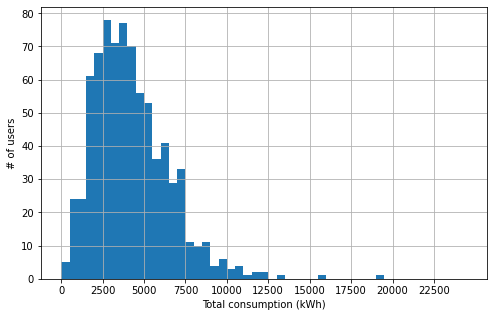

In [60]:
# plot a histogram of consumption
consTotal = hourly_df.sum(axis=1).values   # sum by row (annual aggregate of each users consumption) 
consBins = np.arange(0,25000,500)  # 0 to 30MWh in 500Wh steps
consHist, consEdges = np.histogram(consTotal, consBins, density=False)  #data, bins, False=>consHist contain #samples in each bin.
widths = consEdges[1:]-consEdges[0:-1]  # consEdges=1*50 array ; array[0]=0,array[50]=49000 (bin edges)
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)
ax1.bar(consEdges[0:-1]+widths/2,consHist,width=widths)
ax1.set_xlabel('Total consumption (kWh)')
ax1.set_ylabel('# of users')
ax1.set_xticks(np.arange(0,25000,2500))
ax1.grid(which='both')


In [61]:
# above looks similar in median and shape to LCL data

In [62]:
# user database cleaning - exclude anomalously low usage users (see LCL3)

cutoff = 500  # see histogram above of annual aggregate consumption by user
lowLoadUsers_df = hourly_df.loc[(hourly_df.sum(axis=1).values < cutoff)]  
print("Number of users with annual aggregate usage < ",cutoff," kWh is : ",lowLoadUsers_df.shape[0])

agg_lowLoadUsers = lowLoadUsers_df.sum(axis=0)    # sum each column ie aggregate of all users in input df
uIDsReject = lowLoadUsers_df.index
uIDsAll = hourly_df.index.values   # get all userIDs

uIDs = [x for x in uIDsAll if x not in uIDsReject]
print("# users retained:",len(uIDs))
hourly_df = hourly_df.loc[uIDs]

aggregateLoad = hourly_df.sum(axis=0)    # sum each column ie aggregate of all users at each time 
aggregateLoad



Number of users with annual aggregate usage <  500  kWh is :  5
# users retained: 778


2010-01-01 00:00:00    459.9240
2010-01-01 01:00:00    315.3425
2010-01-01 02:00:00    241.8140
2010-01-01 03:00:00    207.3360
2010-01-01 04:00:00    193.7125
                         ...   
2010-12-31 19:00:00    800.9225
2010-12-31 20:00:00    728.2215
2010-12-31 21:00:00    678.6815
2010-12-31 22:00:00    638.7405
2010-12-31 23:00:00    548.0200
Length: 8760, dtype: float64

In [63]:
# write final hourly_df to pkl file
hourly_df.to_pickle('../MScProjectCoding/project_data/intermediateDataIrelandCER_Data_Step6.hourly_df.pkl')